In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [5]:
data_dict = pd.read_pickle(
    r"C:\Users\cae2\Downloads\TSIS_V10_pickles\V10_prod_all_scans_dict_83_84_85_86_87_88_89_90_91_92_93_94_MD_81_to_2000.pickle"
)
print(f"Imported files with keys {data_dict.keys()}")
df = data_dict[89]
ds = xr.Dataset.from_dataframe(df, sparse=True)

Imported files with keys dict_keys([83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94])


In [10]:
# # create the flat array
# detectors = ds.detector.to_numpy().ravel()
# # iterate through the array and only keep string data
# detectors = [detector for detector in detectors if type(detector) is str]
# # convert to a set to get unique values
# list(set(detectors))

['VIS']

In [11]:
# #create the flat array
# channels = ds.channel.to_numpy().ravel()
# # iterate through the array and only keep string data
# channels = [channel for channel in channels if type(channel) is str]
# # convert to a set to get unique values
# list(set(channels))

['B']

In [12]:
def unique_string_from_sparse_dataarray(da):
    xs = da.to_numpy().ravel()
    xs = [x for x in xs if type(x) is str]
    xs = list(set(xs))
    if len(xs) == 1:
        return xs[0]
    else:
        return xs

In [13]:
#unique_string_from_sparse_dataarray(ds.channel)

'B'

In [14]:
dataset_dict = {
    key: xr.Dataset.from_dataframe(df, sparse=True) for key, df in data_dict.items()
}  # exactly is just data_dict

In [15]:
keys = list(
    dataset_dict.keys()
)  # list because error, and maybe this disconnects data from dictionary
for key in keys:
    ds = dataset_dict.pop(key)
    new_key = unique_string_from_sparse_dataarray(
        ds.channel
    ), unique_string_from_sparse_dataarray(ds.detector)
    dataset_dict[new_key] = ds
#dataset_dict

{('A',
  'ESR'): <xarray.Dataset>
 Dimensions:              (scan_time: 7347, wavelength: 1876)
 Coordinates:
   * scan_time            (scan_time) float64 81.44 81.64 81.83 ... 2e+03 2e+03
   * wavelength           (wavelength) float64 210.0 210.1 ... 2.399e+03
 Data variables:
     pt_time              (scan_time, wavelength) float64 <COO: nnz=303043, fill_value=nan>
     sirr                 (scan_time, wavelength) float64 <COO: nnz=303043, fill_value=nan>
     imode                (scan_time, wavelength) float64 <COO: nnz=303043, fill_value=nan>
     detector             (scan_time, wavelength) object <COO: nnz=303043, fill_value=nan>
     channel              (scan_time, wavelength) object <COO: nnz=303043, fill_value=nan>
     solar_exposure_days  (scan_time, wavelength) float64 <COO: nnz=303043, fill_value=nan>
     activity_name        (scan_time, wavelength) object <COO: nnz=303043, fill_value=nan>,
 ('A',
  'IR'): <xarray.Dataset>
 Dimensions:              (scan_time: 3038, w

In [16]:
#dataset_dict.keys()

dict_keys([('A', 'ESR'), ('A', 'IR'), ('A', 'VIS'), ('A', 'UV'), ('B', 'ESR'), ('B', 'IR'), ('B', 'VIS'), ('B', 'UV'), ('C', 'ESR'), ('C', 'IR'), ('C', 'VIS'), ('C', 'UV')])

In [17]:
#len(dataset_dict)

12

In [18]:
ds = dataset_dict["C", "ESR"]

In [19]:
ds.sirr[:, 500].as_numpy().dropna(dim="scan_time")

<xarray.DataArray 'sirr' (scan_time: 10)>
array([1.77222216, 1.77221754, 1.77190196, 1.7723653 , 1.7721555 ,
       1.77265467, 1.77199934, 1.77268521, 1.77320847, 1.77408486])
Coordinates:
  * scan_time   (scan_time) float64 83.11 293.1 473.3 ... 1.756e+03 1.938e+03
    wavelength  float64 600.1

Text(0.5, 1.0, 'trend for all wavelengths of ESR')

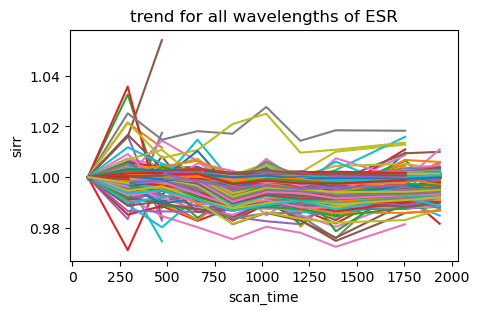

In [21]:
fig, ax = plt.subplots(1)
for n in range(len(ds.wavelength)):
    try:
        da = ds.sirr[:, n].as_numpy().dropna(dim="scan_time")
        da = da / da[0]  # normalize to one for first element
        da.plot(ax=ax)
    except:
        pass  # this ignores all errors. generally a poor way to do it
fig.set_size_inches([5, 3])
ax.set_title("trend for all wavelengths of ESR")

In [22]:
da = ds.sirr[:, 400]  # get the time series of the ESR at the 400th wavelength
da = da.as_numpy()  # convert to numpy array so not sparse now
da = da.dropna(dim="scan_time")  # drop elements with no value
da.interp(scan_time=750)  # interpolate the value to the scan time 750

# note this all could have been a single line just appending the methods at the end

<xarray.DataArray 'sirr' ()>
array(1.99858267)
Coordinates:
    wavelength  float64 494.5
    scan_time   int32 750

In [41]:
ds_ir_b = dataset_dict["A", "IR"]
ds_esr_b = dataset_dict["A", "ESR"]

Text(0, 0.5, 'wavelength exists in\nESR data')

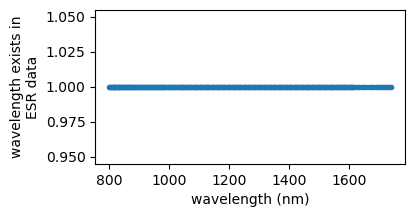

In [42]:
good_wl = [wl in ds_esr_b.wavelength.values for wl in ds_ir_b.wavelength.values]
fig, ax = plt.subplots(1)
ax.plot(ds_ir_b.wavelength.values, good_wl, ".")
fig.set_size_inches([4, 2])
ax.set_xlabel("wavelength (nm)")
ax.set_ylabel("wavelength exists in\nESR data")

In [43]:
ds_combined = xr.combine_by_coords(
    [ds_ir_b.as_numpy(), ds_esr_b.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",
)
ds_combined.as_numpy()

<xarray.Dataset>
Dimensions:              (scan_time: 10385, wavelength: 1876)
Coordinates:
  * scan_time            (scan_time) float64 81.25 81.44 81.64 ... 2e+03 2e+03
  * wavelength           (wavelength) float64 210.0 210.1 ... 2.399e+03
Data variables:
    pt_time              (scan_time, wavelength) float64 nan nan nan ... nan nan
    sirr                 (scan_time, wavelength) float64 nan nan nan ... nan nan
    imode                (scan_time, wavelength) float64 nan nan nan ... nan nan
    detector             (scan_time, wavelength) object nan nan nan ... nan nan
    channel              (scan_time, wavelength) object nan nan nan ... nan nan
    solar_exposure_days  (scan_time, wavelength) float64 nan nan nan ... nan nan
    activity_name        (scan_time, wavelength) object nan nan nan ... nan nan
    sirr_esr             (scan_time, wavelength) float64 nan nan nan ... nan nan

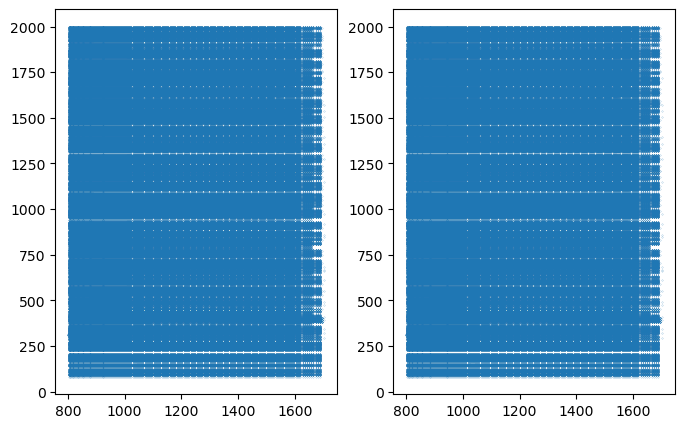

In [44]:
fig,ax = plt.subplots(1,2)
x,y = np.where(ds_ir_b.sirr.to_numpy()>0)
ax[0].plot(ds_ir_b.wavelength.to_numpy()[y],ds_ir_b.scan_time.to_numpy()[x],'.',markersize=.25)
x,y = np.where(ds_combined.sirr.to_numpy()>0)
ax[1].plot(ds_combined.wavelength.to_numpy()[y],ds_combined.scan_time.to_numpy()[x],'.',markersize=.25)
fig.set_size_inches([8,5])

In [45]:
ds_combined["sirr_esr_interp"] = ds_combined.sirr_esr.interpolate_na(
    dim="scan_time", method="linear"
)

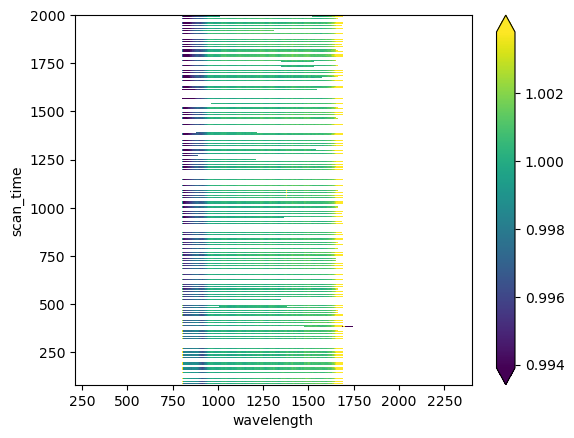

In [46]:
(ds_combined.sirr / ds_combined.sirr_esr_interp).plot(robust = True)

In [47]:
da_ratio = (ds_combined.sirr / ds_combined.sirr_esr_interp)

In [48]:
scan_time = ds_combined.scan_time.to_numpy()
sample_times = np.linspace(scan_time[0], scan_time[-1], 5)

Text(0.5, 1.0, 'IR Spectrum Channel A')

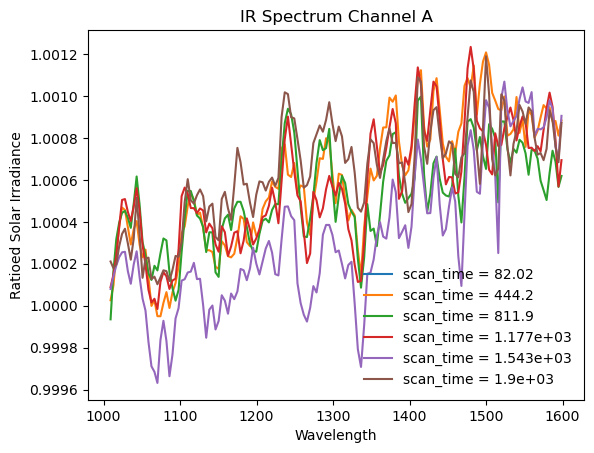

In [51]:
da_ratio_interp = da_ratio.interpolate_na(
    dim="scan_time", method="linear"
)
fig, ax=plt.subplots(1)
da_ratio_interp.sel(scan_time = 82, method = "nearest").sel(wavelength = slice(1009, 1600)).plot(ax=ax)
ax.get_lines()[0].set_label(ax.get_title())
da_ratio_interp.sel(scan_time = 447, method = "nearest").sel(wavelength = slice(1009, 1600)).plot(ax=ax)
ax.get_lines()[1].set_label(ax.get_title())
da_ratio_interp.sel(scan_time = 812, method = "nearest").sel(wavelength = slice(1009, 1600)).plot(ax=ax)
ax.get_lines()[2].set_label(ax.get_title())
da_ratio_interp.sel(scan_time = 1177, method = "nearest").sel(wavelength = slice(1009, 1600)).plot(ax=ax)
ax.get_lines()[3].set_label(ax.get_title())
da_ratio_interp.sel(scan_time = 1543, method = "nearest").sel(wavelength = slice(1009, 1600)).plot(ax=ax)
ax.get_lines()[4].set_label(ax.get_title())
da_ratio_interp.sel(scan_time = 1900, method = "nearest").sel(wavelength = slice(1009, 1600)).plot(ax=ax)
ax.get_lines()[5].set_label(ax.get_title())

ax.legend(frameon= False)
ax.set_ylabel("Ratioed Solar Irradiance")
ax.set_xlabel("Wavelength")
ax.set_title("IR Spectrum Channel A")